## 2D Raw SIM & Ground Truth Images volumetric pre-processing for Deep-learning


<br>
<br>

This notebook onverts 3D SIM stack images into cropped volummteric patchs. <br>
The intent of cropping is to fit data in to the memory of a training GPU. <br>
This code was written for python 3 on NVIDIA TITAN RTX, 32 GB RAM and Processor: Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz (8 CPUs), ~3.6GHz. <br> 

i.e. It hasn't been tested on other any env's <br>

@author Bereket Kebede, bkebede@memphis.edu  <br>

updated Jan 30, 2023

## Getting Started
---- 

In [1]:
########################################
# setting the envinroment 

import sys
sys.path.append("C:/Users/CIRL/AppData/Local\Programs/Python/Python39/Lib/site-packages")
sys.path.append(r"E:\Bereket\Research\DeepLearning - 3D\custom_library")
sys.path.append("C:/Users/CIRL/AppData/Local\Programs/Python/Python36/Lib/site-packages")

In [2]:
########################################
# Import necessary libraries

from PIL import Image
import numpy as np
import numpy
import matplotlib.pyplot as plt
import os
import scipy.ndimage
from skimage import io
from tifffile import imsave
from tifffile import tifffile
from time import process_time

## Import data
----

import RAW SIM and reconstructed data

(Train; 004 & 005), (Validation; is 016) (Testing; is 007)

In [3]:
########################################
# Bring data into phyton notebook

# Data from Opstal et al 2022

# currently doing 004

raw_sim_image_link = r"D:\Bereket\Research\Crawling 3D SIM Data\3D SIM Mitochondria and Lysosomes\LiveCell\eGFP\RawSIM\20210420_H9C2-dTag_GLU_37C_1520_sim-fast_004.tif"
ground_truth_image_link = r"D:\Bereket\Research\Crawling 3D SIM Data\3D SIM Mitochondria and Lysosomes\LiveCell\eGFP\3DSIM\20210420_H9C2-dTag_GLU_37C_1520_sim-fast_004_SIR_ALX.tif"

In [4]:
RS_image = io.imread(raw_sim_image_link) # Wide-field image
GT_image = io.imread(ground_truth_image_link) # Wide-field image

print('Raw_SIM_image size is: ', RS_image.shape)
print('Ground-truth_image size is: ', GT_image.shape)

Raw_SIM_image size is:  (255, 2, 1024, 1024)
Ground-truth_image size is:  (17, 2, 2048, 2048)


Data Format <br>

data type 1: (stack, x, y) <br>
data type 2: (time, stack, x, y) <br>
data type 3: (stack, channel, x, y) <br>


Acquisition format <br>

type 1: change all phase -> change all depth -> change all orientation  <br>

In [5]:
# Hyper-paramters

data_format = "type_3"
orient = 3
phase = 5

RS_image.ndim

4

## Setting Parameters
-----

In [132]:
class calculate_parameters:
    images_per_plane = orient*phase
    if data_format == "type_3":
        total_rawsim_count = RS_image.shape[0]
        depth_count = GT_image.shape[0]
        width = RS_image.shape[2]
        height = RS_image.shape[3]

In [133]:
my_para = calculate_parameters()

images_per_plane = my_para.images_per_plane
total_rawsim_count = my_para.total_rawsim_count
depth_count = my_para.depth_count
width = my_para.width
height = my_para.height

In [164]:
# functions

def clip_normalize_ground(GT_image, data_format = data_format):
    if (data_format == "type_2"):
        temp_GT = GT_image[slide-1].copy()
        temp_GT[temp_GT<0] = 0    #thresholding
        temp_GT = temp_GT/np.max(temp_GT)
    elif (data_format == "type_3"):
        temp_GT = GT_image[:,0,:,:].copy() # at channel 0
        temp_GT[temp_GT<0] = 0    #thresholding
        temp_GT = temp_GT/np.max(temp_GT)
    else:
        temp_GT = GT_image.copy()
        temp_GT[temp_GT<0] = 0    #thresholding
        temp_GT = temp_GT/np.max(temp_GT)
    return temp_GT
        
def clip_normalize_raw(data):
    clipped_data = data.copy() # at channel 0
    clipped_data[clipped_data<0] = 0    #thresholding

    apodized_data = clipped_data - np.min(data)
    norm_3D_data = apodized_data/np.max(apodized_data)
    return norm_3D_data

def structure_raw(RS_image):
    """
    input: (stack, width, height)
    output: (sheets, depth, width, height)
    """
    data = np.zeros((images_per_plane, depth_count, RS_image.shape[RS_image.ndim-2], RS_image.shape[RS_image.ndim-1]))
    block = total_rawsim_count//3
    # change all phase -> change all depth -> change all orientation
    count = 0
    for k in range(orient):
        for i in range(depth_count):
            for j in range(phase):
                # print(k*phase+j+i*block)
                if (data_format == "type_3"):
                    data[j+k*phase,i,:,:] = RS_image[count][0]
                    count +=1;
                elif (data_format == "type_1"):
                    data[phase*i+j,k,:,:] = RS_image[orient*k+j+i*block]
                else:
                    data[phase*i+j,k,:,:] = RS_image[0,orient*k+j+i*block]
    return data

    # expected output:(15, 17, 1024, 1024)

In [165]:
def pre_process_raw(RS_image, orient = 3, phase = 5):
    data = structure_raw(RS_image)
    temp_2 = clip_normalize_raw(data)
    #temp_3 = zero_pad_raw()
    return temp_2

def pre_process_gt(input_image):
    temp_1 = clip_normalize_ground(input_image)
    return temp_1

In [166]:
raw_sim_finalized = pre_process_raw(RS_image)
gt_finalized = pre_process_gt(GT_image)

In [167]:
print(raw_sim_finalized.shape)
print(gt_finalized.shape)

(15, 17, 1024, 1024)
(17, 2048, 2048)


Text(0.5, 1.0, 'Ground-truth_image_FairSIM')

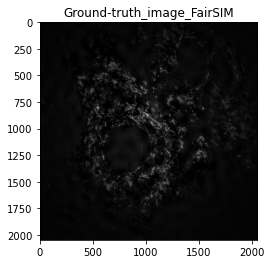

In [187]:
plt.imshow(gt_finalized[8],cmap='gray')
plt.title('Ground-truth_image_FairSIM')

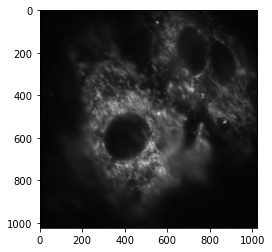

In [176]:
# From the above output we deduce 
# data has a a format of (1,images_per_plane,depth,x,y)
plt.imshow(raw_sim_finalized[0,16,:,:], cmap ='gray')

## Up-Sample z dimension of input from 55 depth to 110, since we expect axial resolution of 2x factor

Text(0.5, 1.0, 'x-z plane Ground truth upsampled at y = 100')

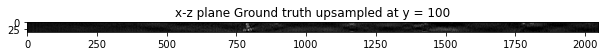

In [178]:
##########################################
# up-sample in the z-dimension 

up_sampled_GT_image = np.repeat(gt_finalized,2, axis=0)
g = plt.figure(figsize=(10.24,1.1))
plt.imshow(up_sampled_GT_image[:,:,99], cmap='gray')
plt.title('x-z plane Ground truth upsampled at y = 100')

## Cropping Input to 32x32x32 and upsampling to 64x64x64
----


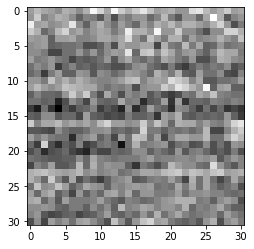

In [184]:
plt.imshow(raw_sim_finalized[0,0,0:31,0:31], cmap ='gray')

In [183]:
data_2 = scipy.ndimage.zoom(raw_sim_finalized, zoom = (1,2,2,2), order = 1)

In [185]:
data_2.shape

(15, 34, 2048, 2048)

In [189]:
os.getcwd()

'E:\\Bereket\\Research\\DeepLearning - 3D\\Workspace\\Data_3D_18'

## Pre-process training data

cropping raw sim blocks into small axa plates

In [193]:
##########################################
# pre-process training data

path = r"E:\Bereket\Research\DeepLearning - 3D\Data\Data_pre_processed\Opstad\Live Cell\004\2D"

f= plt.figure(figsize=(14, 14))
count = 0
c = []

# no of samples = upsampled_depth x patches_per_plane = 64x256 = 16384
# taking only the original 32 depth 

z_grid_size = data_2.shape[1]
y_grid_size = 256
x_grid_size = 256


width_output = data_2.shape[2]
height_output = data_2.shape[3]


t1_start = process_time() 
for z in range(0,z_grid_size):
    print('performed depth: %d/%d'%(z+1, z_grid_size))
    for x in range(0,width_output,x_grid_size):
        for y in range(0,height_output,y_grid_size):
            count +=1
            c = []
            for i in range(images_per_plane):
                c.append(data_2[i,z,x:x+x_grid_size,y:y+y_grid_size])
                #image = scipy.ndimage.zoom(c[i], zoom = (2,2), order = 1)
                image = c[i]
                if(os.path.isdir(path+'/Pattern_illuminated/Sample_%d'%count) == False):
                    os.makedirs(path+'/Pattern_illuminated/Sample_%d'%count)
                imsave(path+'/Pattern_illuminated/Sample_%d/HE_%d.tif' %(count,i+1), image)
                
                
t1_stop = process_time()
print("Elapsed time during the whole program in minutes:",
                                            (t1_stop-t1_start)/60)

performed depth: 1/34
performed depth: 2/34
performed depth: 3/34
performed depth: 4/34
performed depth: 5/34
performed depth: 6/34
performed depth: 7/34
performed depth: 8/34
performed depth: 9/34
performed depth: 10/34
performed depth: 11/34
performed depth: 12/34
performed depth: 13/34
performed depth: 14/34
performed depth: 15/34
performed depth: 16/34
performed depth: 17/34
performed depth: 18/34
performed depth: 19/34
performed depth: 20/34
performed depth: 21/34
performed depth: 22/34
performed depth: 23/34
performed depth: 24/34
performed depth: 25/34
performed depth: 26/34
performed depth: 27/34
performed depth: 28/34
performed depth: 29/34
performed depth: 30/34
performed depth: 31/34
performed depth: 32/34
performed depth: 33/34
performed depth: 34/34
Elapsed time during the whole program in minutes: 0.5393229166666667


<Figure size 1008x1008 with 0 Axes>

## pre-process ground truth

In [19]:
# upsample 2x in z dimension

data_3 = scipy.ndimage.zoom(GT_image, zoom = (2,1,1), order = 1)
data_3.shape

(106, 1024, 1024)

In [34]:
# Example of up-sampling

a = np.array([[1, 1, 1, 1], [2, 2, 2, 2]])
a

array([[1, 1, 1, 1],
       [2, 2, 2, 2]])

In [33]:
a_3 = scipy.ndimage.zoom(a, zoom = (2,1), order = 1)
a_3

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [2, 2, 2, 2]])

In [20]:
# pre-process ground truth

gt_list = []
count = 0

# no of samples = upsampled_depth x patches_per_plane = 64x256 = 16384

for z in range(0,z_grid_size):
    for x in range(0,data_3.shape[1],x_grid_size):
        for y in range(0,data_3.shape[2],y_grid_size ):
            gt_list.append(data_3[z,x:x+x_grid_size,y:y+y_grid_size ])
            image = gt_list[count]
            count +=1
            if not os.path.exists(path+'/Reconstructed'):
                os.makedirs(path+'/Reconstructed')
            imsave(path + '/Reconstructed/Sample_%d.tif' %count, image)

In [29]:
images_per_plane = 15 
data = np.zeros((1, images_per_plane, im.shape[0]//images_per_plane, im.shape[1], im.shape[1]))

## Supplementary

Duplicate directory names for 2D stacking, similar to 3D 

In [1]:
import os
orig_path =  'D:\Bereket\DeepLearning - 3D\Data\Data_3D'
print(os.listdir(orig_path))

['combined_prediction', 'test', 'test_gt', 'test_prediction', 'train', 'train_gt', 'train_prediction', 'valid', 'valid_gt', 'valid_prediction']


In [6]:
destin_path = 'D:/Bereket/DeepLearning - 3D/Data/Data_2D_2'
for dir in os.listdir(orig_path):
    os.makedirs(destin_path+'/'+ dir)

# Split Train, Valid and Test Data

split samples into train, valid and test data 

In [10]:
import shutil, os
train_percent = 0.5
valid_percent = 0.25
test_percent = 0.25

In [11]:
all_pattern_path = 'D:/Bereket/DeepLearning - 3D/Data/Data_pre_processed/2D_Stack_U2OS_Actin/Pattern_illuminated/'
ground_truth_path = 'D:/Bereket/DeepLearning - 3D/Data/Data_pre_processed/2D_Stack_U2OS_Actin/Reconstructed/'

total = len(os.listdir(all_pattern_path))

train_samples = int(total*train_percent)
valid_samples = int(total*valid_percent)
test_samples = int(total*valid_percent)


print('Total dataset: %d'%total)
print('Training range - 1:%d'%train_samples)
print('Validation range - %d:%d'%(train_samples+1,train_samples+valid_samples))
print('Testing range -%d:%d'%(train_samples+valid_samples+1,total))


Total dataset: 16384
Training range - 1:8192
Validation range - 8193:12288
Testing range -12289:16384


In [12]:
train_path = 'D:/Bereket/DeepLearning - 3D/Data/Data_2D_2/train'
test_path = 'D:/Bereket/DeepLearning - 3D/Data/Data_2D_2/test'
valid_path = 'D:/Bereket/DeepLearning - 3D/Data/Data_2D_2/valid'

## Shuttle data from all path to individual TTV(train,test,valid) path

In [19]:
import re, os

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [20]:
dirlist = sorted_alphanumeric(os.listdir(all_pattern_path))
dirlist_gt = sorted_alphanumeric(os.listdir(ground_truth_path))

Training is (1 to 128), (257 to 257+128)  <br>
(256x0 +1 to 256x0 + 128), (256x1 +1 to 256x1 + 128))  <br>
(256xi +1 to 256xi + 128), (256xi +1 to 256xi + 128))  <br>
where i goes from 1 to 64 , aka the depth

![ex](Images/dataset_classification.PNG)

In [7]:
count = 0
for f in dirlist:
    #print(f)
    count +=1
    source = all_pattern_path +'/'+f
    #print(source)
    if (count <= 128):
        a =1+1
        #shutil.copytree(source, train_path +'/'+f)
    if (128 < count <= 128+64):
          
        #print(f)
        #shutil.copytree(source, valid_path +'/'+f)
    if (128+64 < count <= 256):
          
        #shutil.copytree(source, test_path +'/'+f)
    if (count == 256):
        count =0

MOBILIZING GROUND TRUTH

In [23]:
count = 0
for f in dirlist_gt:
    #print(f)
    count +=1
    source = ground_truth_path +'/'+f 
    #print(source)
    if (count <= 128):
        shutil.copy(source, train_path +'_gt/'+f)
    if (128 < count <= 128+64):
        shutil.copy(source, valid_path +'_gt/'+f)
    if (128+64 < count <= 256):
        shutil.copy(source, test_path +'_gt/'+f)
    if (count == 256):
        count =0